# Using scikit-learn implementation of Isolation Forest vs XGBoost to identify fraudulent banknotes in [kaggle](https://www.kaggle.com/dalpozz/creditcardfraud) dataset

In [2]:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import sklearn 
import pandas as pd

import hyperopt
import skopt

from sklearn.ensemble import IsolationForest
from sklearn.model_selection import KFold 
from sklearn import metrics

In [3]:
data = pd.read_csv('creditcard.csv', header=0)
data.rename(columns={'Class': 'class'}, inplace=True)
print(data.head())


   Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...         V21       V22       V23       V24  \
0  0.098698  0.363787  ...   -0.018307  0.277838 -0.110474  0.066928   
1  0.085102 -0.255425  ...   -0.225775 -0.638672  0.101288 -0.339846   
2  0.247676 -1.514654  ...    0.247998  0.771679  0.909412 -0.689281   
3  0.377436 -1.387024  ...   -0.108300  0.005274 -0.190321 -1.175575   
4 -0.270533  0.817739  ...   -0.009431  0.798278 -0.137458  0.141267   

        V25       V26       V27       V28  Amount  class  
0  0.128539 -0.189115

In [4]:
data_no_class = data.drop('class', axis=1)
data0 = data[data['class'] == 0].drop('class', axis=1)
data1 = data[data['class'] == 1].drop('class', axis=1)

# data and target numpy arrays for cross-validation
data_arr = data_no_class.values
target_arr = data['class'].values


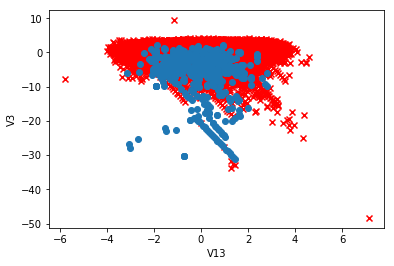

In [5]:
plt.scatter(data0.iloc[:,13], data0.iloc[:,3], marker = 'x', color='r')
plt.scatter(data1.iloc[:,13], data1.iloc[:,3], marker = 'o')
plt.xlabel('V13')
plt.ylabel('V3')

In [6]:
# original class labels are 0 and 1, IsolationForest returns 1 for inliers and -1 for outliers
def to_class_creditcards(a):
    return np.array([0 if x == 1 else 1 for x in np.nditer(a)])

# hyperparameter optimization objective function
def forest_loss(x):   
    losses = []
    cv = KFold(n_splits=3)
    for i_train, i_test in cv.split(data_arr):
        train_data, test_data = data_arr[i_train], data_arr[i_test]
        
        forest = IsolationForest(contamination=x[0], n_estimators=100, max_features=data0.shape[1], 
                                 bootstrap=True, n_jobs=1, verbose=0)        
        forest.fit(data1)
        
        pred_class = to_class_creditcards(forest.predict(test_data))
        actual_class = data['class'].values[i_test]
        
        losses.append(-1 * metrics.accuracy_score(pred_class, actual_class, normalize=True)) 
    
    return np.array(losses).mean()

In [8]:
# hyperparameter optimization using skopt library
skopt_min = skopt.gp_minimize(forest_loss, 
                              [(0.1, 0.9)], 
                              n_calls=100,
                              n_random_starts=10)

argmin: [0.10030956851714797, 61]
f_min: -0.6609334339834182


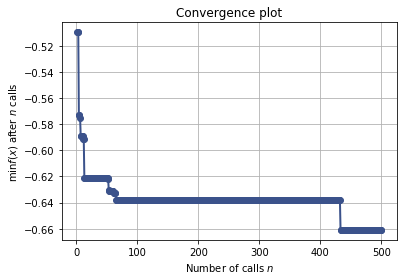

In [12]:
skopt.plots.plot_convergence(skopt_min)
print(f'argmin: {skopt_min.x}')
print(f'f_min: {skopt_min.fun}')

In [22]:
forest = IsolationForest(contamination=0.2, n_estimators=100, max_features=data0.shape[1], 
                         bootstrap=True, n_jobs=1, verbose=0)        
forest.fit(data1)

IsolationForest(bootstrap=True, contamination=0.2, max_features=30,
        max_samples='auto', n_estimators=100, n_jobs=1, random_state=None,
        verbose=0)

In [ ]:
graphviz_tree = xgboost.to_graphviz(model)
graphviz_tree.format = 'png'
graphviz_tree.render('xgboost_tree_credit')

In [23]:
pred_class = (forest.predict(data_arr))
actual_class = data['class'].values

0.0013798818147025881

In [25]:
print(len(pred_class[pred_class==1]))
print(len(pred_class[pred_class==-1]))

274033
10774


In [31]:
pred_class_mapped = to_class_creditcards(pred_class)
print(len(pred_class_mapped[pred_class_mapped==0]))
print(len(pred_class_mapped[pred_class_mapped==1]))
metrics.accuracy_score(pred_class_mapped, actual_class, normalize=True)

274033
10774


0.96113859561036075

In [33]:
metrics.precision_score(pred_class_mapped, actual_class)

0.20121951219512196

In [34]:
metrics.recall_score(pred_class_mapped, actual_class)

0.0091887878225357343

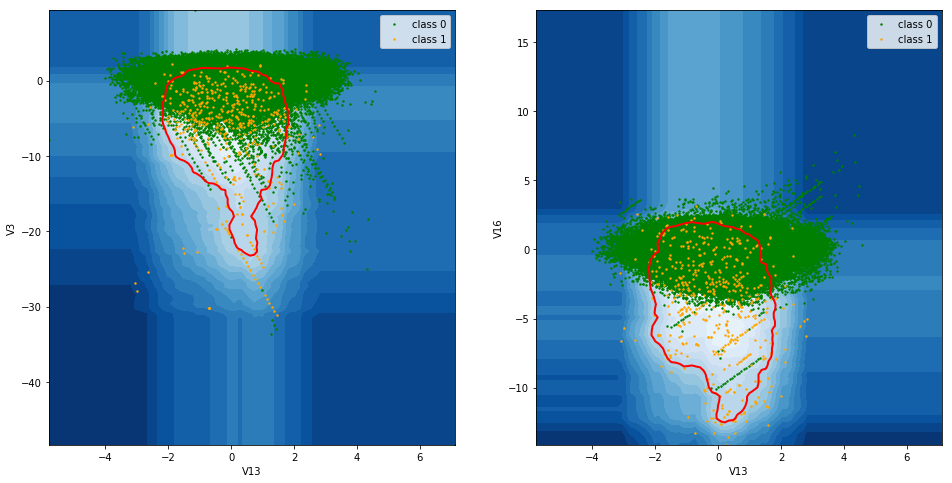

In [21]:
# visualize IsolationTree performance

# outliers_fraction = skopt_min.x[0]
outliers_fraction = 0.2

features = data_no_class.columns
indexed_feature_pairs = [(0, 'V13', 'V3'), (1, 'V13', 'V16')]

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, x_column, y_column in indexed_feature_pairs[:2]:
    isol = IsolationForest(contamination=outliers_fraction, 
                           n_estimators=100,
                           max_features=2)
    
    train_data = data1[[x_column, y_column]]
    isol.fit(train_data)    
    
    ax = axes[i] 
    
    # set axes limits so that all data fits on plot
    xmin, xmax = data[x_column].min(), data[x_column].max()
    ymin, ymax = data[y_column].min(), data[y_column].max()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # prepair mesh for density plots
    n_mesh = 100
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_mesh), np.linspace(ymin, ymax, n_mesh))
    xy = np.c_[xx.ravel(), yy.ravel()]

    score = isol.decision_function(xy)    
    score_grid = score.reshape(xx.shape)
    
    # determine isolation forest score at the decision boundary
    train_data_score = isol.decision_function(train_data)
    score_threshold = np.percentile(train_data_score, 100 * outliers_fraction)
    
    # score density plot
    ax.contourf(xx, yy, score_grid, cmap=plt.cm.Blues_r, 
                levels=list(np.linspace(score.min(), score.max(), 20)))
    # decision boundary plot
    ax.contour(xx, yy, score_grid, levels=[score_threshold], 
               linewidths=2, colors='red', label='threshold')
    
    # class 0 points
    ax.scatter(data0[x_column], data0[y_column], color='g', s=2, label='class 0')
    # class 1 points
    ax.scatter(data1[x_column], data1[y_column], color='orange', s=2, label='class 1')

    ax.set(xlabel=x_column, ylabel=y_column)
    ax.legend()

plt.savefig('isolation_forest_credit.png')

# XGBoost

In [1]:
import xgboost
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split

C:\Users\S\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
seed = 7
test_size = 0.33
trainX, testX, trainY, testY = train_test_split(data_arr, target_arr, test_size=test_size, random_state=seed) 

In [9]:
model = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=100,
                      objective='binary:logistic', nthread=-1, seed=seed)
model.fit(trainX, trainY)

XGBClassifier(base_score=0.5, colsample_bylevel=1, colsample_bytree=1,
       gamma=0, learning_rate=0.1, max_delta_step=0, max_depth=3,
       min_child_weight=1, missing=None, n_estimators=100, nthread=-1,
       objective='binary:logistic', reg_alpha=0, reg_lambda=1,
       scale_pos_weight=1, seed=7, silent=True, subsample=1)

In [10]:
ypred = model.predict(testX)
metrics.average_precision_score(testY, ypred)

0.87881939447668045

In [13]:
# visualize one of the trees of xgboost forest
graphviz_tree = xgboost.to_graphviz(model)
graphviz_tree.format = 'png'
graphviz_tree.render('xgboost_tree_credit')

'xgboost_tree_credit.png'

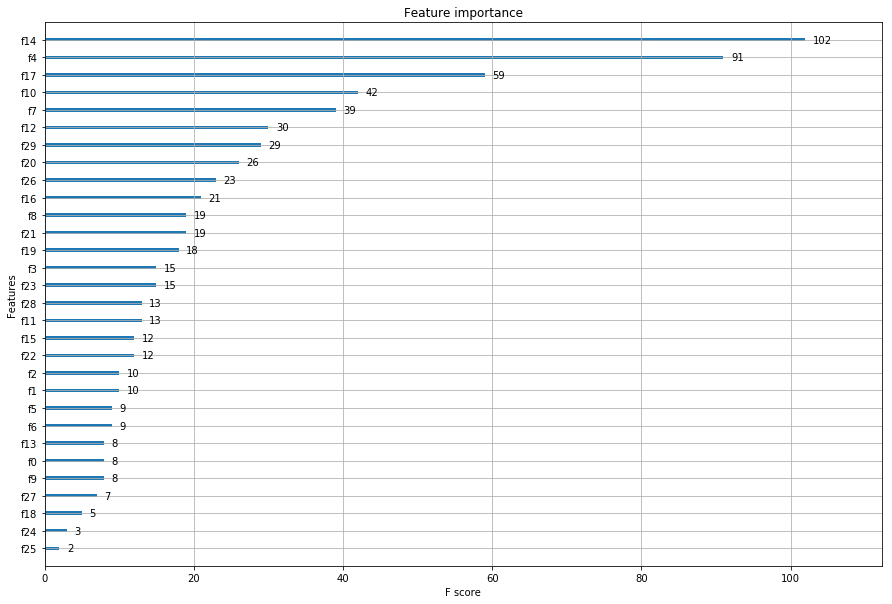

In [11]:
# plor feature importance
plt.figure(figsize=(15, 10))
ax = plt.gca()
xgboost.plot_importance(model, ax=ax)
plt.savefig('xgboost_feature_importance_credit.png')

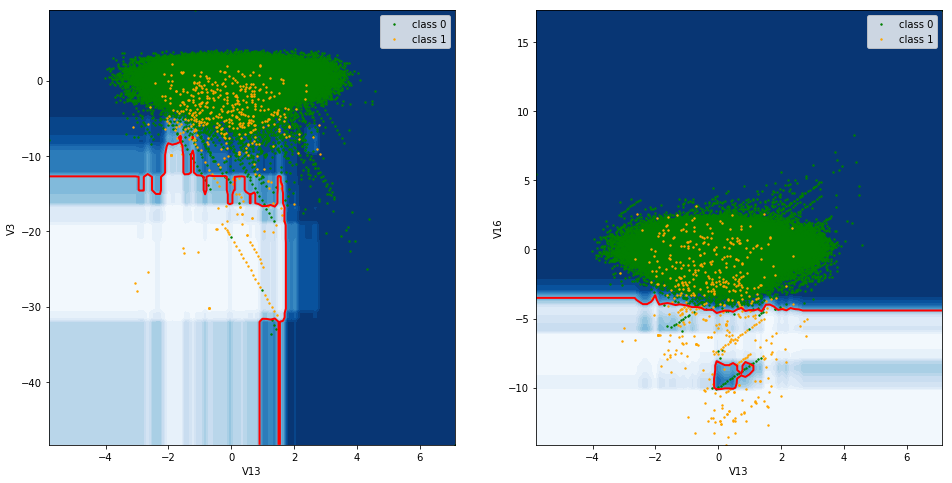

In [13]:
features = data_no_class.columns
indexed_feature_pairs = [(0, 'V13', 'V3'), (1, 'V13', 'V16')]
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

for i, x_column, y_column in indexed_feature_pairs[:2]:
    xgb = XGBClassifier(max_depth=3, learning_rate=0.1, n_estimators=200,
                          objective='binary:logistic', nthread=-1, seed=seed)
    
    train_data = data[[x_column, y_column]].values
    xgb.fit(train_data, data['class'].values)    
    
    ax = axes[i] 
    
    # set axes limits so that all data fits on plot
    xmin, xmax = data[x_column].min(), data[x_column].max()
    ymin, ymax = data[y_column].min(), data[y_column].max()

    ax.set_xlim(xmin, xmax)
    ax.set_ylim(ymin, ymax)
    
    # prepair mesh for density plots
    n_mesh = 100
    xx, yy = np.meshgrid(np.linspace(xmin, xmax, n_mesh), np.linspace(ymin, ymax, n_mesh))
    xy = np.c_[xx.ravel(), yy.ravel()]

    score = xgb.predict_proba(xy)[:,1]  
    score_grid = score.reshape(xx.shape)
    
    # score density plot
    ax.contourf(xx, yy, score_grid, cmap=plt.cm.Blues_r, 
                levels=list(np.linspace(score.min(), score.max(), 20)))
    # decision boundary plot
    ax.contour(xx, yy, score_grid, levels=[0.5], 
               linewidths=2, colors='red', label='threshold')
    
    # class 0 points
    ax.scatter(data0[x_column], data0[y_column], color='g', s=2, label='class 0')
    # class 1 points
    ax.scatter(data1[x_column], data1[y_column], color='orange', s=2, label='class 1')

    ax.set(xlabel=x_column, ylabel=y_column)
    ax.legend()

plt.savefig('xgboost_credit.png')